In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import xgboost as xgb

/home/sgu/miniconda2/envs/GAPM/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
df_properties_2016 = pd.read_csv("properties_2016.csv")
df_train_2016 = pd.read_csv("train_2016_v2.csv")
df_properties_2016.shape, df_train_2016.shape

((2985217, 58), (90275, 3))

In [6]:
df = pd.merge?

In [7]:
df = df_train_2016.merge(df_properties_2016, on='parcelid')
df.shape

(90275, 60)

In [15]:
zip(np.percentile(np.abs(df.logerror.values),range(0,101,10)),range(0,101,10))

[(0.0, 0),
 (0.0050000000000000001, 10),
 (0.0109, 20),
 (0.016899999999999998, 30),
 (0.024299999999999999, 40),
 (0.032500000000000001, 50),
 (0.044000000000000004, 60),
 (0.058299999999999991, 70),
 (0.0843, 80),
 (0.14499999999999999, 90),
 (4.7370000000000001, 100)]

In [39]:
df_x = df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'],axis=1)
df_y = df['logerror']
df_x.shape, df_y.shape

((90275, 55), (90275,))

In [40]:
sel = df_x.dtypes == object
cols_obj = df_x.dtypes[sel].index.values
df_x[cols_obj].apply(lambda s: dict(s.value_counts()), axis=0)

hashottuborspa        {True: 2365}
fireplaceflag          {True: 222}
taxdelinquencyflag    {u'Y': 1783}
dtype: object

In [41]:
for c in cols_obj: 
    df_x[c] = (df_x[c] == True) | (df_x[c]=='Y')

In [42]:
df_x.dtypes.value_counts()

float64    52
bool        3
dtype: int64

In [59]:
t = np.random.rand(len(df_x))
sel_train = t <0.7
sel_valid = np.logical_and(t>=0.7, t<0.9) 
sel_test = np.logical_and(~sel_train,~sel_valid)
df_x_train, df_x_valid, df_x_test = df_x[sel_train], df_x[sel_valid], df_x[sel_test]
df_y_train, df_y_valid, df_y_test = df_y[sel_train], df_y[sel_valid], df_y[sel_test]
df_x_train.shape, df_y_train.shape, df_x_valid.shape, df_y_valid.shape, df_x_test.shape, df_y_test.shape

((63045, 55), (63045,), (18222, 55), (18222,), (9008, 55), (9008,))

In [60]:
d_train = xgb.DMatrix(df_x_train, label=df_y_train.values)
d_valid = xgb.DMatrix(df_x_valid, label=df_y_valid.values)
d_test = xgb.DMatrix(df_x_test, label=df_y_test.values)
d_train.num_row(), d_train.num_col(),d_valid.num_row(), d_valid.num_col(), d_test.num_row(), d_test.num_col()

(63045L, 55L, 18222L, 55L, 9008L, 55L)

In [125]:
params = {
    'eta': 0.9, #step size shrinkage
    'objective':'reg:linear',
    'max_depth': 4, 
    'subsample': 0.9, #select 80% samples to build a tree each round 
    'eval_metric': 'mae',#mean absolute error
    'silent':1  #turn off verbose
}

In [126]:
gbm = xgb.train(params,d_train, num_boost_round=1000, evals=[(d_train,'train'),(d_valid,'test')],
                early_stopping_rounds=100,  #eval metric has to decrease every 100 rounds for d_valid
                verbose_eval=10, #print eval metrics every 10 rounds
               )

[0]	train-mae:0.088975	test-mae:0.090926
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 100 rounds.
[10]	train-mae:0.067746	test-mae:0.07121
[20]	train-mae:0.06742	test-mae:0.072096
[30]	train-mae:0.067175	test-mae:0.07315
[40]	train-mae:0.066846	test-mae:0.07369
[50]	train-mae:0.066643	test-mae:0.074787
[60]	train-mae:0.06627	test-mae:0.07536
[70]	train-mae:0.066209	test-mae:0.076211
[80]	train-mae:0.06608	test-mae:0.077154
[90]	train-mae:0.065767	test-mae:0.078082
[100]	train-mae:0.065536	test-mae:0.078563
Stopping. Best iteration:
[2]	train-mae:0.067903	test-mae:0.070208



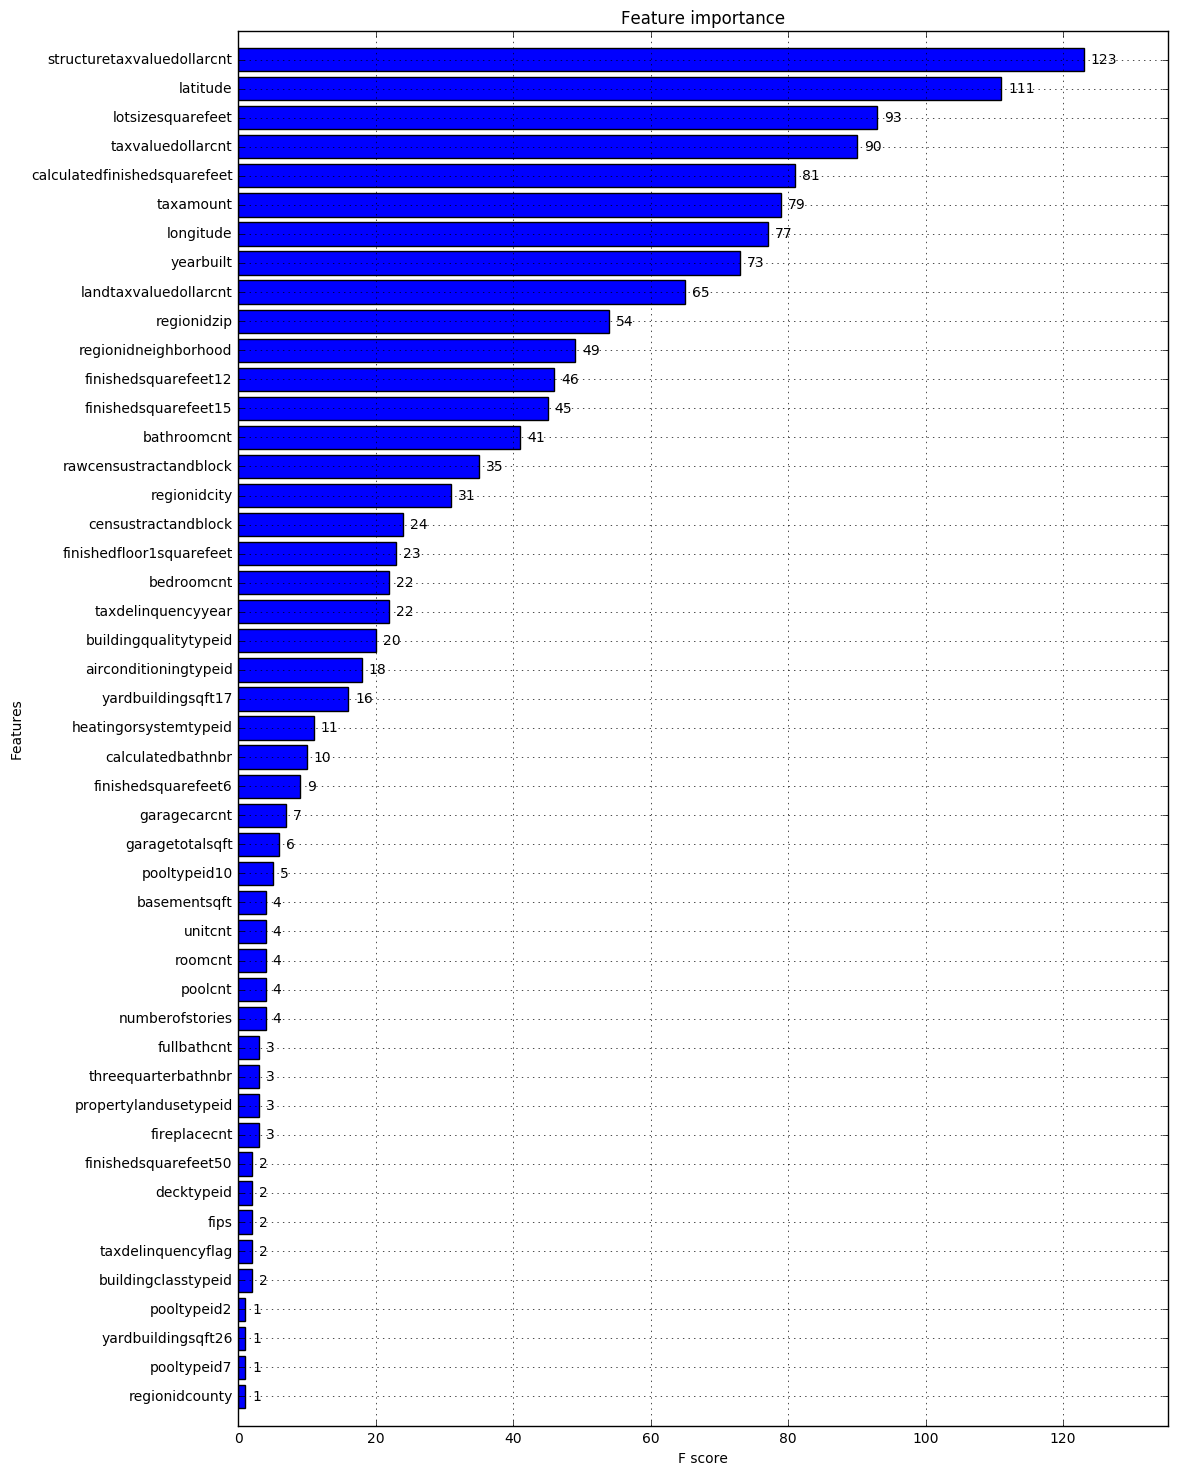

In [127]:
fig,ax = plt.subplots(figsize=(12,18)) #12in-by-12in image, otherwise legend overlaps. 
xgb.plot_importance(gbm,height=0.8, ax=ax)
plt.show()

In [128]:
#predict
y_test_pred= gbm.predict(d_test)
y_train_pred = gbm.predict(d_train)
y_valid_pred = gbm.predict(d_valid)

In [129]:
y_test_true=df[sel_test].logerror.values
y_train_true=df[sel_train].logerror.values
y_valid_true=df[sel_valid].logerror.values

In [130]:
y_mean = np.mean(y_train_true)
y_mean

0.011392380045998889

In [131]:
#calculate r2; very low!
r2_test = 1.0- np.sum((y_test_true - y_test_pred)**2)/np.sum((y_test_true-y_mean)**2)
r2_train = 1.0- np.sum((y_train_true - y_train_pred)**2)/np.sum((y_train_true-y_mean)**2)
r2_valid = 1.0- np.sum((y_valid_true - y_valid_pred)**2)/np.sum((y_valid_true-y_mean)**2)
r2_train, r2_valid, r2_test

(0.31414325716479741, -0.17416721004015678, -0.17780136036988958)

In [132]:
# try to use mae 
f_mae = lambda x: np.mean(np.abs(x))
r_test = 1.0- f_mae(y_test_true - y_test_pred)/f_mae(y_test_true-y_mean)
r_train = 1.0- f_mae(y_train_true - y_train_pred)/f_mae(y_train_true-y_mean)
r_valid = 1.0- f_mae(y_valid_true - y_valid_pred)/f_mae(y_valid_true-y_mean)
r_train, r_valid, r_test

(0.038037791385203912, -0.12848331344537312, -0.1450903754520827)

In [118]:
f_mae(y_train_true - y_train_pred),f_mae(y_train_true - y_mean)

(0.06678040295355836, 0.068056621528363712)

<function __main__.<lambda>>